In [46]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns

from sklearn import preprocessing
from sklearn.utils import check_X_y,check_array
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, ConstantKernel
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import random
import time
import dataclasses
from typing import List,Union
import pickle

import warnings
warnings.filterwarnings('ignore')

In [47]:
plt.rcParams["font.size"] = 15
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15
plt.rcParams["axes.titlesize"] = 15
plt.rcParams["font.family"] = 'Times New Roman'

### 準備

In [48]:
# データの前準備
csv_df = pd.read_csv('../input/tsta_a_1791676_sm7407.csv')

# 分析データクラスの定義
@dataclasses.dataclass
class MaterialDataset:
    dataset_name: Union[str,None] = None
    x_name_list: Union[List[str],None] = None
    y_name_list: Union[List[str],None] = None
    data: Union[pd.DataFrame,None] = None


# 不要列を削除
drop = ['ID', 'Elongation (%)','Tensile strength (Mpa)']
csv_df = csv_df.drop(drop, axis=1)

# データクラスの作成
dataset = MaterialDataset()
dataset.dataset_name = 'tsta_a_1791676_sm7407'
dataset.x_name_list = list(csv_df.columns[:-1])
dataset.y_name_list = list(csv_df.columns[-1:])

# 重複データの平均値化
csv_df = csv_df.groupby(dataset.x_name_list)[dataset.y_name_list].agg(lambda x: x.unique().mean())
csv_df = csv_df.reset_index()

dataset.data = csv_df 

# 目的変数のデータで大きい順に並び替え
# proof stress (Mpa)の場合360が最大値でデータ中には1点のみ。次点の320が3点存在する。
csv_df.sort_values(by=dataset.y_name_list, ascending=False).head(20)

,X,n,Fe (wt%),Mn (wt%),Si (wt%),Al (wt%),Mg (wt%),Ti (wt%),Cu (wt%),Cr (wt%),Zn (wt%),2% proof stress (Mpa)
40,1,8,0.20,0.13,0.15,94.25,5.05,0.00,0.05,0.13,0.050,360.0
48,1,9,0.18,0.35,0.10,95.58,3.50,0.05,0.08,0.05,0.125,320.0
47,1,9,0.18,0.35,0.10,94.58,4.50,0.05,0.08,0.05,0.125,320.0
107,3,8,0.20,0.13,0.15,94.25,5.05,0.00,0.05,0.13,0.050,320.0
36,1,8,0.18,0.35,0.10,95.58,3.50,0.05,0.08,0.05,0.125,300.0
114,4,8,0.18,0.08,0.10,94.83,4.50,0.05,0.08,0.08,0.125,300.0
44,1,8,0.25,0.45,0.20,94.70,4.00,0.08,0.05,0.15,0.125,285.0
111,3,8,0.25,0.45,0.20,94.70,4.00,0.08,0.05,0.15,0.125,285.0
72,2,6,0.25,0.45,0.20,94.70,4.00,0.08,0.05,0.15,0.125,265.0
103,3,6,0.25,0.45,0.20,94.70,4.00,0.08,0.05,0.15,0.125,265.0


In [49]:
# 獲得関数の準備
class EI():
    def __init__(self, xi :float = 0):
        # xi can also use 0.01
        self.xi = xi
    def calc_ac(self, X, model, y_best):
        mean, std = model.pred_dist(X)
        z = (mean - y_best - self.xi)/std
        return (mean - y_best - self.xi) * norm.cdf(z) + std * norm.pdf(z), mean , std
    
class RandomValue():
    def __init__(self):
        pass
    def calc_ac(self, X, model, y_best):
        np.random.seed(0)
        value = np.random.randint(0, 1, len(X)).reshape(-1,1)
        return value, value , value 

In [50]:
# 予測モデルの準備
class BoModel():
    def __init__(self):
        pass

    def fit(self, X,Y):
        X, Y = check_X_y(X, Y, accept_sparse=True, y_numeric=True)
        self.model = GaussianProcessRegressor().fit(X, Y)
        return self
    
    def predict(self, X):
        X = check_array(X, accept_sparse=True)
        pred_value = self.model.predict(X,return_std =True)
        y_test = pred_value[0]

        return y_test

    def pred_dist(self, X):
        X = check_array(X, accept_sparse=True)
        pred_value = self.model.predict(X,return_std =True)
        y_test, std= pred_value[0], pred_value[1]

        return y_test,std

In [51]:
class OptBenchmark:
    def __init__(self):
        self.index_collection = []
        self.y_best_trend_collection = []
        self.y_pred_mean_collection = []
        self.y_pred_std_collection = []
        self.total_time = None
        self.batch_size = None

    def calc_pool_opt(self,model, mat_dataset, ac_class, n_exp_initial: int = 50, n_ensemble: int = 5, result_save_name :str="result", iterations :int= -1):
        
        # 計算時間の算出：計算開始時間の格納
        start_time = time.time()

        # データの取得
        x_all = mat_dataset.data[mat_dataset.x_name_list].values
        y_all = mat_dataset.data[mat_dataset.y_name_list].values.ravel()
        all_data_num = mat_dataset.data[mat_dataset.x_name_list].shape[0]

        np.random.seed(0)
        seed_list = [int(x) for x in np.random.randint(0, 10000, n_ensemble)]

        # 学習データの上位10%のサンプルを初期点に含まないように準備
        threshold = np.percentile(y_all, 90)
        top_10_percent_indices = np.where(y_all >= threshold)[0]

        # 最適化計算セットの繰り返し
        for ensemble_num in range(n_ensemble):
            print(f'ensumble num = {ensemble_num}, initializing seed = {str(seed_list[ensemble_num])}')
            random.seed(seed_list[ensemble_num])

            # index_learn_pool：未実験の候補のリスト
            # index_obserbed : 実験済みのリスト。初期実験点の数をランダムにサンプリング
            index_all_pool = list(np.arange(all_data_num))
            index_under_pool = [i for i in index_all_pool if i not in top_10_percent_indices]
            index_observed = random.sample(index_under_pool, n_exp_initial)
            index_learn_pool = [i for i in index_all_pool if i not in index_observed]

            # LOOで初期点におけるモデル性能の評価
            if ac_class.__class__.__name__ != 'RandomValue':
                self._calc_loo(x_all[index_observed,:],y_all[index_observed],model)
            
            # 結果を格納するリスト
            y_best_trend_list = []
            y_pred_mean_list = []
            y_std_mean_list = []

            # iterationsの数値が-1の場合は全ての候補を評価。そうでない場合には設定しただけの実験を実施
            if iterations == -1:
                iterations = len(index_learn_pool)
            elif iterations > len(index_learn_pool):
                iterations = len(index_learn_pool)
            for _ in np.arange(iterations):
                next_index = None
                x_observed = x_all[index_observed,:]
                y_observed = y_all[index_observed]

                x_scaler = preprocessing.StandardScaler()
                y_scaler = preprocessing.StandardScaler()            
                x_train_std = x_scaler.fit_transform(x_observed)
                x_all_std = x_scaler.transform(x_all)
                y_observed_std = y_scaler.fit_transform(y_observed.reshape(-1,1)).ravel()
                y_best_std = np.max(y_observed_std)
                model.fit(x_train_std, y_observed_std)

                # 獲得関数を計算して次の候補indexを選択。選択されたindexを実験済みに追加。未実験リストから削除
                ac_value_array, y_pred_mean_array, y_pred_std_array = ac_class.calc_ac(x_all_std, model, y_best_std)
                next_index = self._sample_select(ac_value_array, index_learn_pool, index_observed)
                index_observed.append(next_index)
                index_learn_pool.remove(next_index)
                
                y_pred_mean = y_scaler.inverse_transform(y_pred_mean_array[next_index].reshape(-1,1))
                y_std_mean = y_scaler.inverse_transform(y_pred_std_array[next_index].reshape(-1,1))

                y_best_trend_list.append(np.max(y_observed))
                y_pred_mean_list.append(y_pred_mean[0][0])
                y_std_mean_list.append(y_std_mean[0][0])
            else:
                y_observed = y_all[index_observed]
                y_best_trend_list.append(np.max(y_observed))
                
                self.index_collection.append(index_observed)
                self.y_best_trend_collection.append(y_best_trend_list)
                self.y_pred_mean_collection.append(y_pred_mean_list)
                self.y_pred_std_collection.append(y_std_mean_list)
            
        self.total_time = time.time() - start_time
        
        if result_save_name is not None:
            save_path = fr'../output/{result_save_name}'
            with open(save_path, 'wb') as f:
                pickle.dump(self, f)

        return self

    def _sample_select(self,ac_value_array, index_learn_pool, index_observed):
        max_ac = np.max(ac_value_array[index_learn_pool])
        max_pool_index = np.where(ac_value_array == max_ac)[0].tolist()
        max_pool_index = [i for i in max_pool_index if i not in index_observed]

        # 同じ獲得関数の値がある場合にはランダムに候補を選択
        next_index = random.sample(max_pool_index,1)[0]
        
        return next_index
    
    def _calc_loo(self,train_X, train_Y,model):

        oof = np.zeros(len(train_X))
        folds = len(train_X)
        kf = KFold(n_splits=folds)

        scaler_x = preprocessing.StandardScaler()
        scaler_y = preprocessing.StandardScaler()

        for train_index, valid_index in kf.split(train_X):
            X_train = scaler_x.fit_transform(train_X[train_index,:])
            X_valid = scaler_x.transform(train_X[valid_index,:])
            y_train = scaler_y.fit_transform(train_Y[train_index].reshape(-1, 1))

            model.fit(X_train, y_train)
            y_pred_valid = scaler_y.inverse_transform(model.predict(X_valid).reshape(-1, 1))

            oof[valid_index] = y_pred_valid

        self._plot_loo(train_Y, oof)

    def _plot_loo(self,train_Y, oof):
        # oofをActualとPredictedに分けてプロット
        plt.figure(figsize=(6, 6))
        plt.title("Predicted vs Actual")
        plt.scatter(train_Y, oof, label="valid", color="red", marker="*", s=100)
        x_truth = np.arange(train_Y.min(), train_Y.max() + 1)
        y_truth = x_truth
        plt.plot(x_truth, y_truth, "--", color="gray", label="truth")
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        # plt.textでRMSE, MAE, R2を右下に表示
        plt.text(
            0.6,
            0.3,
            f"RMSE_valid: {np.sqrt(mean_squared_error(train_Y, oof)):.2f}",
            transform=plt.gca().transAxes,
        )
        plt.text(
            0.6,
            0.2,
            f"MAE_valid: {mean_absolute_error(train_Y, oof):.2f}",
            transform=plt.gca().transAxes,
        )
        plt.text(
            0.6, 0.1, f"R2_valid: {r2_score(train_Y, oof):.2f}", transform=plt.gca().transAxes
        )
        plt.legend()
        plt.show()


    def calc_avg_performance(self):
        result_dic = {'y_best_trend':self._calc_ave_array(self.y_best_trend_collection),
                    'y_pred_mean':self._calc_ave_array(self.y_pred_mean_collection),
                    'y_pred_std':self._calc_ave_array(self.y_pred_std_collection)
                    }

        return result_dic

    def _calc_ave_array(self, result_list):
        avg_array = np.zeros(len(result_list[0])) 
        for one_result in result_list:
            avg_array += np.array(one_result)
        avg_array = avg_array / len(result_list)
        return avg_array

## 最適化計算の実施

In [52]:
# 計算設定
n_ensemble = 5

model_dic = {'GP':BoModel()}
ac_dic = {'EI':EI(),'Random':RandomValue()}
eval_list = ['random']
dataset_list = [dataset]

GP_EI_tsta_a_1791676_sm7407_5ensemble
ensumble num = 0, initializing seed = 2732


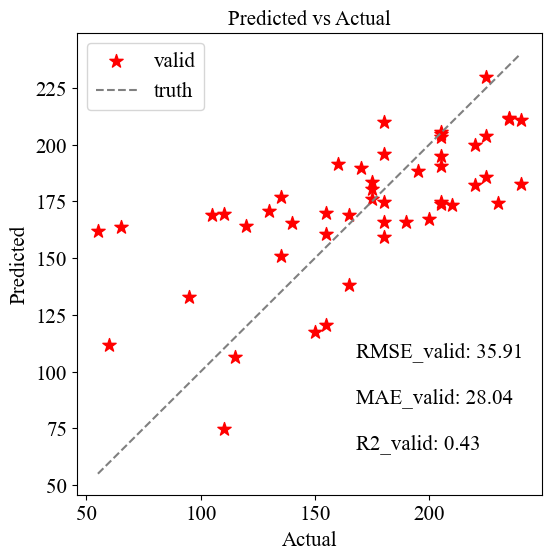

ensumble num = 1, initializing seed = 9845


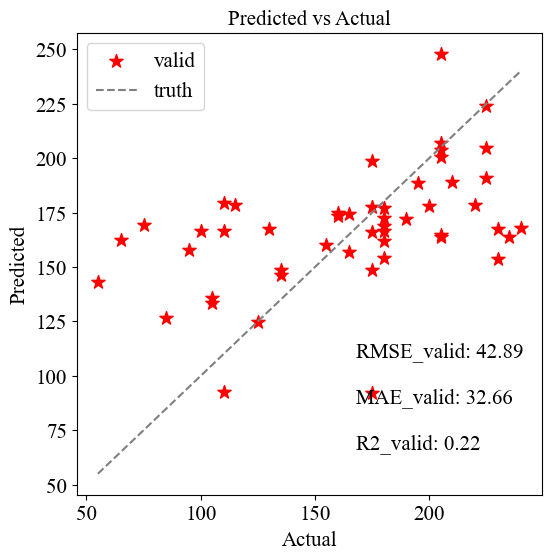

ensumble num = 2, initializing seed = 3264


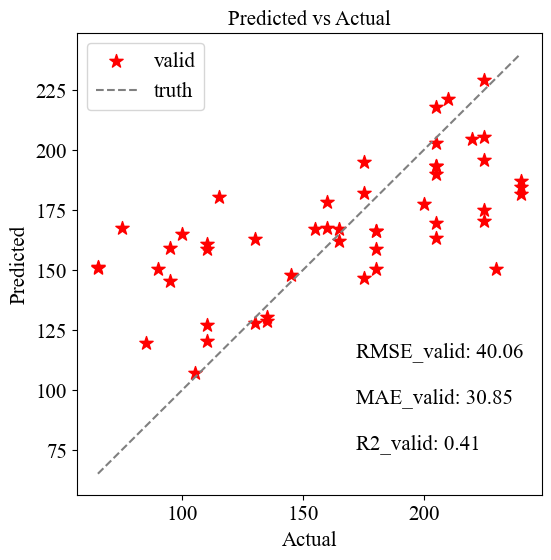

ensumble num = 3, initializing seed = 4859


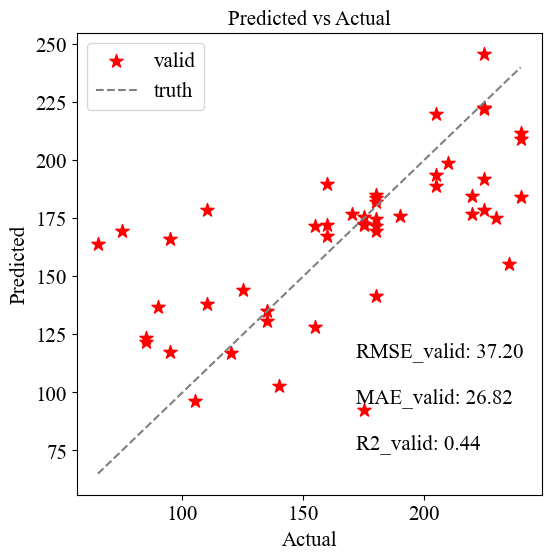

ensumble num = 4, initializing seed = 9225


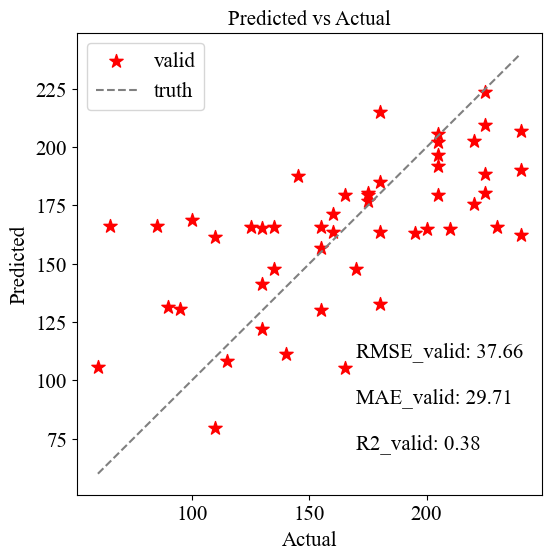

GP_Random_tsta_a_1791676_sm7407_5ensemble
ensumble num = 0, initializing seed = 2732
ensumble num = 1, initializing seed = 9845
ensumble num = 2, initializing seed = 3264
ensumble num = 3, initializing seed = 4859
ensumble num = 4, initializing seed = 9225


In [53]:
# 実験セット
for model_name,model in model_dic.items():
    for data in dataset_list:
        for ac_name, ac in ac_dic.items():
            bm_opt = OptBenchmark()
            result_save_name = f'{model_name}_{ac_name}_{data.dataset_name}_{n_ensemble}ensemble'     
            print(result_save_name)
            bm_opt.calc_pool_opt(model, data, ac, n_ensemble =n_ensemble, result_save_name =result_save_name)

## 結果の可視化

In [54]:
def plot_best_trend(perfomance_dataset_dic,n_ensemble,baseline_dataset=None):

    fig = plt.figure(figsize=(8,8))
    ax0 = fig.add_subplot(111)
    plt.title("Trend of Best Value")
    plt.xlabel("Trend")
    plt.ylabel("Best Value")

    if baseline_dataset is not None:
        n_b_data = len(baseline_dataset.data)
        best_value = np.max(baseline_dataset.data[baseline_dataset.y_name_list].values)

        ax0.plot(np.linspace(1, n_b_data, n_b_data), np.full(n_b_data,best_value),'--',color='black',linewidth = 2)    
        plt.title(f"Trend of Best Value:{data.y_name_list[0]}")

    color_list = ["r", "b", "g", "y", "m", "c"]
    i = 0
    for perfomance_k, perfomance_i in perfomance_dataset_dic.items():
        
        n_p_data = len(perfomance_i['y_best_trend'])
        y_trend = perfomance_i['y_best_trend']

        ax0.plot(np.arange(n_p_data) + 1, y_trend, label = perfomance_k, color = color_list[i], linewidth=2)

        for j in range(n_ensemble):
            y_trend = perfomance_i['y_best_trend_list'][j]
            ax0.plot(np.arange(n_p_data) + 1, y_trend,'--',color = color_list[i], linewidth=1,alpha=0.5)

        ax0.legend()
        ax0.set_xlim([0, 100])
        i += 1

In [55]:
exp_name_list1 = ['GP_EI_tsta_a_1791676_sm7407_5ensemble'
                ,'GP_Random_tsta_a_1791676_sm7407_5ensemble'
                ] 

perfomance_dataset_dic = {}
for exp_name in exp_name_list1:
    perfomance_dataset_dic[exp_name] = {}
    pickle_path = fr'../output/{exp_name}'
    with open(pickle_path, 'rb') as f:
        result = pickle.load(f)
        print(f'計算時間 {exp_name}:',result.total_time)
        performance_result = result.calc_avg_performance()
        perfomance_dataset_dic[exp_name]["y_best_trend"] = performance_result["y_best_trend"]
        perfomance_dataset_dic[exp_name]["y_best_trend_list"] = result.y_best_trend_collection

計算時間 GP_EI_tsta_a_1791676_sm7407_5ensemble: 3.265106201171875
計算時間 GP_Random_tsta_a_1791676_sm7407_5ensemble: 0.8443930149078369


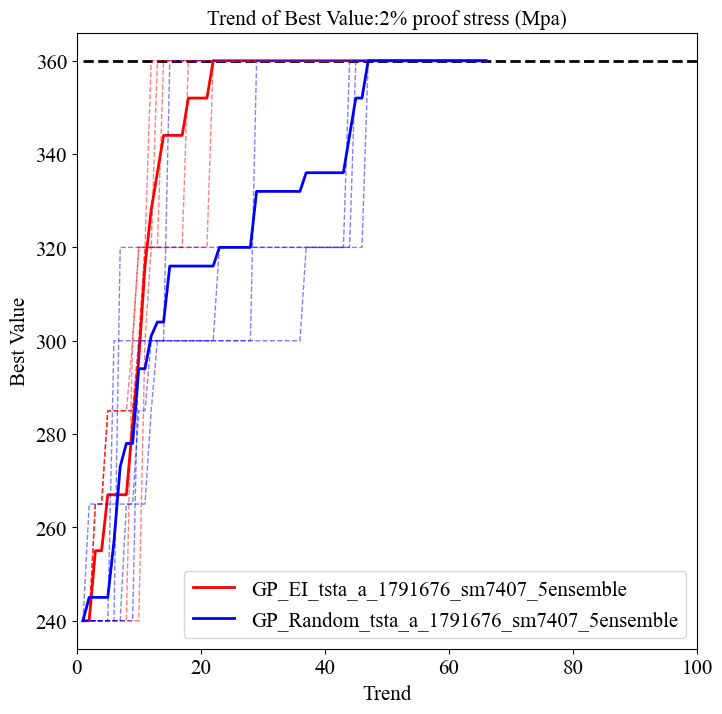

In [56]:
plot_best_trend(perfomance_dataset_dic,n_ensemble,dataset)